In [7]:
!pip3 install ortools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip3 install ColabTurtle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from ortools.sat.python import cp_model
from ColabTurtle.Turtle import *

# Functions

In [8]:
def print_slant(puzzle,lines):
  for x,i in enumerate(puzzle[:-1]):
    print(" ".join(i))
    a=" "
    for b in lines[x]:
      if b=="R":
        a+= "/ "
      else:
        a+="\\ "
    print(a)
  print(" ".join(puzzle[-1]))

def print_solution(lines):
  for i in lines:
    a=" "
    for b in i:
      if b=="R":
        a+= "/ "
      else:
        a+="\\ "
    print(a)

In [9]:
def isCyclicRec(lines,i,j,x,y, visited, parent):
  visited[i][j] = True
  for di in [-1, 1]:
    for dj in [-1, 1]:
      ni, nj = i + di, j + dj
      mi, mj = int(di != -1),int(dj != -1)
      if 0 <= ni < x and 0 <= nj < y:
        if (lines[nj-mj][ni-mi]=="L" and ((di==-1 and dj==-1) or (di==1 and dj==1))) or (
            lines[nj-mj][ni-mi]=="R" and ((di==1 and dj==-1) or (di==-1 and dj==1))):
          if not visited[ni][nj]:
            found=isCyclicRec(lines,ni,nj,x,y, visited, (i,j));
            if found:
              return True
          elif parent != (ni,nj):
            return True
  return False
# checks if there is cycle using DFS
def isCyclic(lines):
  x=len(lines[0])+1
  y=len(lines)+1
  visited=[]
  for i in range(x):
    v=[]
    for j in range(y):
      v.append(False)
    visited.append(v)
  for i in range(x):
    for j in range(y):
      if visited[i][j] == False:
        found=isCyclicRec(lines,i,j,x,y, visited, (-1,-1));
        if found:
          return True
  return False

In [10]:
def print_turtle(puzz,lines):
  initializeTurtle(10,((len(lines))*50+200,(len(lines[0]))*50+200))
  for row in range(len(lines)):
    for col in range(len(lines[0])):
      penup()
      goto(100+col * 50, 100+row * 50)
      pendown()
      width(1)
      backward(50)
      right(90)
      forward(50)
      left(90)
      forward(50)
      left(90)
      forward(50)
      if lines[row][col] == "L":
        right(45)
        width(4)
        backward(70)
        width(1)
        right(45)
        forward(50)
      else:
        left(270)
        backward(50)
        right(45)
        width(4)
        forward(70)
        left(45)

  for row in range(len(puzz)):
    for col in range(len(puzz[0])):
      penup()
      goto(100+col * 50, 100+row * 50)
      pendown()
      if puzz[row][col] != "*":
        penup()
        backward(20)
        left(90)
        forward(13)
        color("red")
        write(puzz[row][col], font=(50,"Arial","bold"))
        color("white")
        left(180)
        forward(13)
        left(90)
        left(180)
        backward(20)
        left(180)
        pendown()
  penup()
  goto(0,0)

# Solution

In [11]:
class solveUntilAcyclic(cp_model.CpSolverSolutionCallback):
  def __init__(self,variables,rows,cols,print_solution=False,print_slant=False,print_turtle=False,puzzle=None):
    cp_model.CpSolverSolutionCallback.__init__(self)
    self.__variables = variables
    self.__puzzle = puzzle
    self.__rows = rows-1
    self.__cols = cols-1
    self.__print_solution = print_solution
    self.__print_slant    = print_slant
    self.__print_turtle   = print_turtle
  def on_solution_callback(self):
    # solve while there is cycle
    solution=[]
    for i in range(self.__rows):
      row = []
      for j in range(self.__cols):
        if self.Value(self.__variables[2*(i*self.__rows+j)])==1:
          row.append("R")
        else:
          row.append("L")
      solution.append(row)
    # check if there is a cycle with DFS
    if not isCyclic(solution):
      self.StopSearch()
      if(self.__print_solution):
        print_solution(solution)
      if(self.__print_slant):
        print_slant(self.__puzzle,solution)
      if(self.__print_turtle):
        print_turtle(self.__puzzle,solution)
      return solution

def solve_diagonal_puzzle(puzzle,stats=False,print_solution=False,print_slant=False,print_turtle=False):
  model = cp_model.CpModel()
  rows, cols = len(puzzle), len(puzzle[0])
  variables = {}
  # add bool variables
  for i in range(rows-1):
    for j in range(cols-1):
      variables[(i, j, "R")] = model.NewBoolVar(f"line_{i}_{j}_R")
      variables[(i, j, "L")] = model.NewBoolVar(f"line_{i}_{j}_L")
      model.Add(variables[(i, j, "R")] != variables[(i, j, "L")])
  # add neighour constraints
  for i in range(rows):
    for j in range(cols):
      if(puzzle[i][j]!="*"):
        available=[]
        for di in [-1, 1]:
          for dj in [-1, 1]:
            ni, nj = i + di, j + dj
            mi=int(di != -1)
            mj=int(dj != -1)
            if 0 <= ni < rows and 0 <= nj < cols:
              if (((di==-1 and dj==-1) or (di==1 and dj==1))):
                available.append(variables[(ni-mi, nj-mj, "L")])
              elif (((di==1 and dj==-1) or (di==-1 and dj==1))):
                available.append(variables[(ni-mi, nj-mj, "R")])
        model.Add(sum(available) == int(puzzle[i][j]))
  solver = cp_model.CpSolver()
  solver.parameters.enumerate_all_solutions = True
  status = solver.Solve(model,solveUntilAcyclic(list(variables.values()),rows,cols,print_solution,print_slant,print_turtle,puzzle))
  if stats:
    print(solver.ResponseStats())

# Test


In [3]:
epuzzle = [[["0", "1", "*", "*", "*", "*"],
            ["*", "1", "*", "3", "1", "*"],
            ["*", "2", "2", "*", "2", "*"],
            ["*", "2", "2", "*", "*", "1"],
            ["*", "*", "*", "2", "1", "*"],
            ["*", "2", "*", "2", "*", "*"]],
           [["*", "*", "2", "*", "*", "1"], 
            ["0", "*", "2", "3", "*", "*"],
            ["*", "*", "*", "*", "2", "*"],
            ["1", "*", "*", "1", "*", "1"],
            ["*", "1", "4", "*", "2", "*"],
            ["*", "1", "*", "*", "0", "*"]],
           [["*", "*", "1", "2", "*", "*"],
            ["*", "1", "*", "*", "4", "*"],
            ["*", "2", "*", "*", "2", "*"],
            ["*", "*", "*", "2", "*", "1"],
            ["2", "*", "*", "2", "2", "*"],
            ["*", "2", "*", "*", "*", "0"]],
           [["*", "0", "*", "*", "*", "*"],
            ["0", "*", "2", "3", "1", "*"],
            ["*", "3", "*", "*", "*", "2"],
            ["*", "*", "4", "*", "*", "1"],
            ["2", "*", "*", "3", "*", "*"],
            ["*", "1", "*", "*", "1", "*"]],
           [["*", "*", "1", "*", "0", "*"],
            ["0", "2", "*", "*", "*", "*"],
            ["*", "1", "*", "1", "4", "*"],
            ["0", "*", "*", "1", "*", "2"],
            ["*", "*", "*", "*", "2", "*"],
            ["0", "*", "0", "1", "*", "*"]]]

mpuzzle = [[["*", "1", "2", "*", "*", "*", "2", "1", "1", "*", "1"],
            ["*", "3", "*", "2", "*", "*", "*", "*", "*", "*", "*"],
            ["1", "1", "*", "*", "*", "2", "*", "*", "*", "3", "*"],
            ["1", "2", "*", "3", "*", "1", "*", "*", "3", "*", "*"],
            ["1", "2", "1", "3", "*", "2", "2", "1", "*", "*", "1"],
            ["*", "*", "*", "2", "3", "*", "*", "2", "*", "3", "0"],
            ["*", "1", "*", "*", "1", "*", "1", "4", "*", "*", "1"],
            ["1", "3", "*", "1", "*", "*", "1", "1", "3", "*", "1"],
            ["1", "2", "3", "*", "*", "2", "*", "*", "3", "*", "*"],
            ["1", "2", "2", "*", "*", "*", "2", "1", "*", "*", "*"],
            ["1", "*", "*", "*", "0", "*", "*", "*", "*", "0", "*"]],
           
           [["*", "2", "1", "*", "*", "1", "1", "1", "*", "*", "1"],
            ["*", "2", "2", "*", "2", "3", "*", "*", "1", "2", "1"],
            ["*", "2", "*", "2", "*", "*", "4", "*", "*", "1", "*"],
            ["*", "2", "*", "*", "*", "2", "2", "1", "*", "*", "*"],
            ["1", "1", "*", "*", "3", "2", "2", "2", "*", "2", "*"],
            ["*", "*", "*", "2", "*", "*", "*", "*", "3", "*", "*"],
            ["*", "3", "2", "*", "*", "*", "*", "3", "2", "*", "1"],
            ["*", "*", "4", "*", "3", "*", "*", "3", "*", "*", "1"],
            ["*", "1", "1", "*", "1", "4", "*", "*", "*", "*", "*"],
            ["1", "*", "1", "*", "2", "2", "*", "3", "1", "*", "1"],
            ["*", "*", "*", "1", "*", "*", "*", "*", "*", "1", "*"]],
           
           [["*", "*", "*", "*", "1", "*", "*", "0", "*", "1", "*"],
            ["1", "1", "*", "1", "*", "*", "1", "2", "*", "*", "*"],
            ["0", "*", "2", "*", "*", "1", "*", "2", "2", "*", "*"],
            ["1", "1", "3", "*", "*", "1", "3", "3", "*", "3", "*"],
            ["*", "1", "*", "2", "*", "2", "1", "*", "*", "1", "*"],
            ["1", "3", "*", "*", "2", "2", "*", "*", "2", "*", "*"],
            ["*", "2", "*", "2", "*", "2", "*", "3", "*", "1", "*"],
            ["0", "3", "2", "*", "2", "*", "3", "2", "*", "*", "2"],
            ["*", "2", "*", "3", "*", "2", "*", "3", "2", "*", "*"],
            ["*", "*", "*", "*", "3", "*", "2", "*", "*", "2", "*"],
            ["*", "*", "0", "1", "*", "*", "*", "*", "1", "1", "*"]],
           
           [["*", "*", "2", "*", "2", "*", "2", "*", "2", "*", "*"],
            ["*", "2", "*", "2", "2", "*", "*", "2", "1", "2", "*"],
            ["*", "3", "*", "*", "*", "*", "3", "*", "*", "1", "*"],
            ["*", "*", "1", "2", "3", "*", "2", "*", "*", "*", "*"],
            ["0", "*", "*", "3", "*", "2", "1", "3", "2", "*", "*"],
            ["1", "*", "1", "*", "*", "*", "*", "3", "*", "*", "1"],
            ["*", "2", "*", "2", "1", "*", "*", "2", "*", "2", "0"],
            ["1", "*", "*", "1", "*", "2", "3", "*", "*", "*", "*"],
            ["*", "3", "*", "*", "1", "1", "*", "*", "3", "2", "0"],
            ["0", "*", "*", "*", "3", "2", "*", "*", "*", "1", "*"],
            ["*", "1", "*", "*", "*", "2", "*", "*", "0", "*", "*"]],
           
           [["*", "*", "*", "0", "1", "*", "*", "*", "*", "2", "*"],
            ["*", "2", "*", "3", "*", "3", "*", "1", "*", "*", "2"],
            ["2", "*", "*", "*", "2", "*", "1", "2", "*", "*", "1"],
            ["*", "4", "*", "*", "3", "2", "*", "*", "*", "3", "*"],
            ["*", "*", "*", "2", "*", "*", "2", "4", "*", "*", "*"],
            ["2", "*", "*", "*", "*", "4", "*", "*", "3", "*", "1"],
            ["*", "*", "1", "*", "2", "*", "3", "*", "*", "2", "0"],
            ["1", "*", "1", "3", "*", "*", "*", "2", "*", "*", "1"],
            ["2", "*", "*", "1", "*", "1", "2", "1", "2", "2", "*"],
            ["*", "2", "2", "2", "*", "*", "2", "2", "*", "*", "1"],
            ["1", "*", "*", "*", "*", "2", "1", "*", "*", "2", "*"]]]

hpuzzle = [[["1", "*", "2", "*", "0", "1", "*", "2", "1", "*", "1", "*", "0"],
            ["*", "*", "2", "2", "*", "*", "*", "2", "*", "*", "*", "2", "*"],
            ["2", "*", "*", "3", "*", "*", "3", "*", "*", "3", "1", "*", "*"],
            ["1", "*", "*", "2", "1", "3", "*", "*", "*", "1", "*", "2", "1"],
            ["1", "*", "2", "2", "*", "1", "*", "2", "1", "3", "*", "*", "2"],
            ["*", "*", "2", "*", "3", "*", "*", "2", "*", "*", "*", "4", "*"],
            ["*", "3", "*", "*", "*", "2", "2", "2", "*", "2", "2", "*", "*"],
            ["*", "*", "*", "2", "3", "2", "2", "1", "*", "2", "3", "*", "*"],
            ["2", "*", "2", "*", "*", "1", "*", "*", "2", "3", "*", "2", "1"],
            ["1", "3", "*", "3", "*", "*", "*", "1", "*", "2", "*", "1", "1"],
            ["*", "*", "*", "2", "*", "*", "3", "*", "3", "2", "*", "*", "0"],
            ["*", "4", "*", "*", "4", "*", "1", "3", "2", "1", "2", "*", "*"],
            ["*", "*", "*", "1", "*", "*", "*", "*", "*", "*", "*", "2", "*"]],
           
           [["*", "2", "*", "1", "1", "*", "2", "*", "1", "*", "0", "*", "*"],
            ["*", "*", "2", "*", "1", "*", "*", "1", "*", "*", "3", "2", "0"],
            ["*", "1", "2", "*", "*", "*", "3", "*", "*", "1", "1", "2", "*"],
            ["*", "*", "2", "*", "*", "3", "*", "*", "*", "*", "3", "*", "*"],
            ["*", "2", "2", "*", "1", "*", "*", "2", "2", "3", "*", "*", "0"],
            ["1", "*", "3", "*", "*", "3", "*", "*", "3", "*", "1", "*", "1"],
            ["*", "1", "*", "3", "3", "*", "*", "2", "*", "2", "3", "*", "*"],
            ["*", "*", "4", "*", "*", "*", "*", "3", "*", "1", "*", "*", "*"],
            ["*", "3", "2", "*", "*", "1", "*", "*", "*", "1", "1", "2", "*"],
            ["*", "*", "*", "3", "*", "2", "4", "*", "*", "3", "*", "*", "*"],
            ["*", "2", "*", "*", "1", "*", "2", "3", "*", "2", "1", "*", "1"],
            ["0", "*", "4", "*", "*", "*", "2", "*", "3", "*", "1", "2", "2"],
            ["*", "*", "*", "*", "*", "*", "*", "*", "*", "*", "*", "*", "*"]],
           
           [["*", "*", "*", "0", "*", "1", "1", "*", "2", "1", "*", "0", "*"],
            ["*", "2", "*", "*", "3", "1", "*", "*", "1", "*", "2", "3", "*"],
            ["*", "2", "4", "*", "*", "*", "*", "3", "*", "3", "*", "*", "2"],
            ["1", "*", "*", "*", "1", "3", "*", "*", "*", "*", "*", "2", "*"],
            ["*", "3", "2", "*", "*", "2", "2", "*", "2", "2", "3", "*", "*"],
            ["*", "*", "3", "*", "*", "1", "*", "3", "1", "*", "3", "*", "1"],
            ["*", "3", "*", "*", "*", "2", "1", "1", "*", "*", "*", "1", "*"],
            ["*", "*", "2", "3", "1", "3", "2", "*", "2", "*", "2", "*", "*"],
            ["1", "*", "*", "1", "4", "1", "1", "2", "3", "2", "*", "1", "*"],
            ["*", "*", "4", "*", "2", "*", "3", "*", "*", "1", "*", "3", "*"],
            ["*", "2", "*", "*", "*", "*", "*", "4", "*", "*", "1", "*", "*"],
            ["0", "*", "*", "2", "*", "2", "*", "1", "1", "3", "2", "*", "*"],
            ["*", "*", "0", "1", "*", "*", "1", "*", "*", "*", "1", "2", "*"]],
           
           [["0", "*", "*", "*", "1", "*", "*", "*", "*", "*", "*", "1", "*"],
            ["*", "*", "*", "3", "*", "2", "3", "*", "3", "*", "2", "*", "0"],
            ["*", "4", "1", "*", "1", "4", "*", "1", "*", "4", "1", "*", "*"],
            ["*", "*", "3", "2", "*", "*", "1", "*", "*", "*", "3", "*", "2"],
            ["*", "*", "2", "2", "*", "*", "*", "*", "*", "2", "*", "*", "*"],
            ["*", "2", "*", "*", "*", "*", "*", "2", "*", "*", "*", "4", "*"],
            ["0", "3", "*", "1", "2", "2", "3", "1", "2", "2", "*", "2", "*"],
            ["*", "*", "3", "*", "*", "2", "1", "*", "*", "*", "*", "*", "*"],
            ["*", "*", "*", "1", "*", "*", "2", "1", "2", "*", "2", "*", "0"],
            ["*", "2", "4", "*", "*", "1", "2", "*", "3", "1", "2", "2", "*"],
            ["*", "1", "*", "2", "4", "*", "*", "*", "*", "*", "*", "2", "2"],
            ["*", "*", "2", "*", "*", "2", "*", "3", "2", "*", "3", "*", "*"],
            ["*", "1", "*", "2", "*", "*", "*", "0", "*", "1", "*", "1", "*"]],
           
           [["*", "*", "1", "*", "2", "1", "*", "*", "*", "*", "*", "2", "*"],
            ["0", "*", "*", "1", "2", "*", "2", "*", "1", "*", "2", "*", "1"],
            ["*", "2", "*", "*", "*", "*", "*", "3", "*", "*", "*", "2", "*"],
            ["*", "*", "2", "4", "*", "1", "*", "*", "2", "3", "*", "2", "*"],
            ["0", "*", "*", "*", "1", "3", "*", "*", "1", "*", "2", "*", "*"],
            ["1", "1", "*", "3", "*", "2", "*", "2", "*", "*", "*", "*", "2"],
            ["*", "3", "*", "*", "3", "1", "*", "2", "*", "*", "2", "1", "*"],
            ["*", "*", "*", "1", "2", "*", "2", "2", "1", "2", "2", "3", "*"],
            ["2", "*", "*", "*", "*", "*", "*", "3", "*", "*", "*", "2", "1"],
            ["*", "1", "*", "1", "3", "*", "2", "3", "1", "*", "*", "2", "*"],
            ["*", "4", "2", "1", "1", "3", "*", "*", "*", "3", "2", "*", "*"],
            ["*", "*", "3", "*", "*", "*", "3", "*", "*", "*", "1", "*", "1"],
            ["*", "*", "*", "*", "*", "1", "1", "2", "*", "2", "*", "1", "*"]]]

xpuzz =    [["*", "*", "1", "1", "*", "*", "2", "*", "*", "2", "*", "0", "1", "*"],
            ["*", "1", "*", "*", "*", "1", "*", "*", "1", "1", "*", "*", "1", "*"],
            ["1", "2", "*", "1", "*", "*", "*", "3", "*", "*", "3", "*", "3", "*"],
            ["0", "3", "1", "2", "*", "2", "2", "2", "*", "2", "*", "2", "*", "1"],
            ["1", "2", "*", "2", "*", "1", "*", "*", "*", "*", "*", "*", "*", "*"],
            ["*", "2", "2", "*", "2", "*", "*", "*", "*", "*", "3", "*", "*", "0"],
            ["*", "*", "4", "*", "*", "2", "*", "2", "1", "2", "1", "*", "1", "*"],
            ["1", "2", "*", "*", "*", "*", "1", "1", "*", "2", "*", "3", "*", "*"],
            ["*", "2", "*", "*", "*", "1", "*", "*", "*", "1", "*", "2", "3", "*"],
            ["*", "*", "2", "*", "*", "3", "1", "*", "3", "*", "4", "*", "*", "*"],
            ["*", "1", "*", "2", "2", "*", "*", "3", "*", "2", "*", "*", "*", "1"],
            ["0", "3", "*", "2", "*", "*", "*", "*", "1", "3", "*", "*", "1", "*"],
            ["1", "1", "*", "1", "*", "*", "2", "4", "*", "*", "*", "3", "*", "*"],
            ["*", "*", "0", "1", "1", "*", "*", "*", "2", "*", "0", "*", "*", "1"]]
            

In [10]:
avr=[]
etimes=[]
for puzz in epuzzle:
  start = time.perf_counter_ns()
  iter=1000
  for i in range(iter):
    solve_diagonal_puzzle(puzz)
  stop = time.perf_counter_ns()
  etimes.append(round((stop-start)/10**6/iter,2))
  print(round((stop-start)/10**6/iter,2))
avr.append(round(sum(etimes) / len(etimes),2))
print(etimes)
print("EAVR:",round(sum(etimes) / len(etimes),2))
mtimes=[]
for puzz in mpuzzle:
  start = time.perf_counter_ns()
  iter=100
  for i in range(iter):
    solve_diagonal_puzzle(puzz)
  stop = time.perf_counter_ns()
  mtimes.append(round((stop-start)/10**6/iter,2))
  print(round((stop-start)/10**6/iter,2))
avr.append(round(sum(mtimes) / len(mtimes),2))
print(mtimes)
print("MAVR:",round(sum(mtimes) / len(mtimes),2))
htimes=[]
for puzz in hpuzzle:
  start = time.perf_counter_ns()
  iter=10
  for i in range(iter):
    solve_diagonal_puzzle(puzz)
  stop = time.perf_counter_ns()
  htimes.append(round((stop-start)/10**6/iter,2))
  print(round((stop-start)/10**6/iter,2))
avr.append(round(sum(htimes) / len(htimes),2))
print(htimes)
print("HAVR:",round(sum(htimes) / len(htimes),2))
print(avr)

4.38
6.04
6.53
5.84
2.99
[4.38, 6.04, 6.53, 5.84, 2.99]
EAVR: 5.16
370.61
476.43
1708.22
175.99
170.36
[370.61, 476.43, 1708.22, 175.99, 170.36]
MAVR: 580.32
HAVR: 4823.96
HAVR: 36106.63
HAVR: 346.96
HAVR: 45393.08
HAVR: 19517.48
[4823.96, 36106.63, 346.96, 45393.08, 19517.48]
21237.62
[5.16, 580.32, 21237.62]


In [11]:
for puzz in epuzzle:
  solve_diagonal_puzzle(puzz,True)
for puzz in mpuzzle:
  solve_diagonal_puzzle(puzz,True)
for puzz in hpuzzle:
  solve_diagonal_puzzle(puzz,True)

CpSolverResponse summary:
status: OPTIMAL
objective: 0
best_bound: 0
integers: 4
booleans: 50
conflicts: 0
branches: 0
propagations: 50
integer_propagations: 2
restarts: 0
lp_iterations: 0
walltime: 0.00214322
usertime: 0.00214329
deterministic_time: 8.32e-06
gap_integral: 0
solution_fingerprint: 0xe311fb24b93a948

CpSolverResponse summary:
status: FEASIBLE
objective: 0
best_bound: 0
integers: 6
booleans: 50
conflicts: 0
branches: 5
propagations: 55
integer_propagations: 14
restarts: 5
lp_iterations: 0
walltime: 0.00448805
usertime: 0.00448807
deterministic_time: 1.57e-05
gap_integral: 0
solution_fingerprint: 0xf3db1c22a06f2efc

CpSolverResponse summary:
status: FEASIBLE
objective: 0
best_bound: 0
integers: 6
booleans: 50
conflicts: 0
branches: 10
propagations: 56
integer_propagations: 21
restarts: 9
lp_iterations: 0
walltime: 0.00143194
usertime: 0.00143197
deterministic_time: 1.892e-05
gap_integral: 0
solution_fingerprint: 0xe2deadb61ee4fdd1

CpSolverResponse summary:
status: FEASIBL

In [12]:
#solve_diagonal_puzzle(puzzle,stats=False,print_solution=False,print_slant=False,print_turtle=False)
solve_diagonal_puzzle(mpuzzle[0],False,False,False,False)

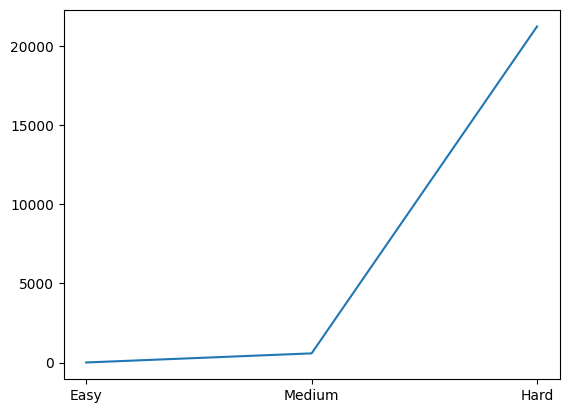

In [19]:
import matplotlib.pyplot as plt

plt.plot(["Easy","Medium","Hard"],avr)
plt.show()

# Trash

In [13]:
def count_around(lines):
  counts=[]
  x=len(lines[0])+1
  y=len(lines)+1
  for i in range(x):
    c=[]
    for j in range(y):
      count=0
      for di in [0, 1]:
        for dj in [0, 1]:
          ni, nj = i + di, j + dj
          if 0 < ni < x and 0 < nj < y:
            if (lines[ni-1][nj-1]=="L" and ((di==0 and dj==0) or (di==1 and dj==1))) or (lines[ni-1][nj-1]=="R" and ((di==1 and dj==0) or (di==0 and dj==1))):
              count+=1
      c.append(count)
    counts.append(c)
  return counts           

In [12]:
def print_turtle_all_lines(puzz):
  initializeTurtle(13,((len(puzz)-1)*50+200,(len(puzz[0])-1)*50+200))
  for row in range(len(puzz)-1):
    for col in range(len(puzz[0])-1):
      penup()
      goto(100+col * 50, 100+row * 50)
      pendown()
      width(1)
      backward(50)
      right(90)
      forward(50)
      left(90)
      forward(50)
      left(90)
      forward(50)
      
      right(45)
      width(4)
      color("green")
      backward(70)
      color("white")
      width(1)
      right(45)
      forward(50)
      left(90)
      forward(50)
      right(90)

      backward(50)
      right(45)
      width(4)
      color("blue")
      forward(70)
      color("white")
      left(45)
  for row in range(len(puzz)):
    for col in range(len(puzz[0])):
      penup()
      goto(100+col * 50, 100+row * 50)
      pendown()
      if puzz[row][col] != "*":
        penup()
        backward(20)
        left(90)
        forward(13)
        color("red")
        write(puzz[row][col], font=(50,"Arial","bold"))
        color("white")
        left(180)
        forward(13)
        left(90)
        left(180)
        backward(20)
        left(180)
        pendown()
  penup()
  goto(0,0)
print_turtle_all_lines(mpuzzle[0])

In [13]:
for i in epuzzle[0]:
  print(i)
solve_diagonal_puzzle(epuzzle[0],True,False,True,False)
for i in epuzzle[0]:
  print(i)
solve_diagonal_puzzle(mpuzzle[0],True,False,True,False)
for i in epuzzle[0]:
  print(i)
solve_diagonal_puzzle(hpuzzle[0],True,False,True,False)


['0', '1', '*', '*', '*', '*']
['*', '1', '*', '3', '1', '*']
['*', '2', '2', '*', '2', '*']
['*', '2', '2', '*', '*', '1']
['*', '*', '*', '2', '1', '*']
['*', '2', '*', '2', '*', '*']
0 1 * * * *
 / / \ / \ 
* 1 * 3 1 *
 \ / \ \ \ 
* 2 2 * 2 *
 \ / \ \ \ 
* 2 2 * * 1
 \ / \ / \ 
* * * 2 1 *
 \ / \ / / 
* 2 * 2 * *
CpSolverResponse summary:
status: OPTIMAL
objective: 0
best_bound: 0
integers: 4
booleans: 50
conflicts: 0
branches: 0
propagations: 50
integer_propagations: 2
restarts: 0
lp_iterations: 0
walltime: 0.0146619
usertime: 0.0146622
deterministic_time: 8.32e-06
gap_integral: 0
solution_fingerprint: 0xe311fb24b93a948

['0', '1', '*', '*', '*', '*']
['*', '1', '*', '3', '1', '*']
['*', '2', '2', '*', '2', '*']
['*', '2', '2', '*', '*', '1']
['*', '*', '*', '2', '1', '*']
['*', '2', '*', '2', '*', '*']
* 1 2 * * * 2 1 1 * 1
 / / \ / / / \ \ \ / 
* 3 * 2 * * * * * * *
 / \ \ / / \ \ \ \ / 
1 1 * * * 2 * * * 3 *
 / / \ / / \ \ \ / / 
1 2 * 3 * 1 * * 3 * *
 / / \ \ / / \ \ \ / 
1 2 1